In [1]:
!date

Thu May 22 12:14:37 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

In [4]:
def pretty_t_test(vec1,vec2,ttl,alternative='two-sided'):
    from scipy.stats import ttest_rel
    t,p = ttest_rel(np.arctanh(vec1),np.arctanh(vec2),alternative=alternative) # Fisher Z transform before t-testing
    degf = len(vec1)-1
    diff = vec1.mean()-vec2.mean()

    if p < .001:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p < .001')
    else:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p = {p:.3f}')

In [5]:
def plot_scatter(vec1,vec2,xlabel='',ylabel='',title=''):
    plt.scatter(vec1, vec2, color='blue', label='Data points',s=150)
    f = 20
    plt.xticks(fontsize=f)
    plt.yticks(fontsize=f)

    # Adding the parity line (where y = x)
    # Determine the limits for the line based on the data range:
    min_val = min(np.min(vec1), np.min(vec2))
    max_val = max(np.max(vec1), np.max(vec2))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Parity line (y=x)')

    # Add labels and title
    plt.xlabel(xlabel,fontsize=16,fontweight='bold')
    plt.ylabel(ylabel,fontsize=16,fontweight='bold')
    plt.grid(True)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def pretty_bar_plot(
    means,
    sems,
    bar_colors=['#003f5c', '#003f5c', '#00bcd4'],
    bar_edge_thickness=2.5,
    errorbar_thickness=3.5,
    tick_fontsize=20,
    tick_fontweight='bold',
    label_fontsize=22,
    y_max=None,
    significance_bars=[((0, 1), '*'), ((0, 2), '*'), ((1, 2), '*')],
    x_labels=['None', 'CompCor', 'DeepCor'],
    bar_spacing=1.2
):
    """

    Parameters:
        means, sems: List of means and standard errors.
        bar_colors: List of bar fill colors.
        bar_edge_thickness: Thickness of bar outline.
        errorbar_thickness: Thickness of error bars.
        tick_fontsize, tick_fontweight: Tick label styling.
        label_fontsize: Font size for axis labels.
        y_max: Optional y-axis limit.
        significance_bars: List of tuples ((bar1, bar2), marker).
        x_labels: Labels for each bar.
        bar_spacing: Distance between bars (default = 1.2).
    """
    
    n_bars = len(means)
    xs = np.arange(n_bars) * bar_spacing

    fig, ax = plt.subplots(figsize=(7, 9))

    # Bar plot with error bars
    ax.bar(xs, means, yerr=sems, capsize=10,
           color=bar_colors,
           edgecolor='black',
           linewidth=bar_edge_thickness,
           ecolor='black',
           error_kw=dict(linewidth=errorbar_thickness),
           zorder=2)

    # Axes and tick formatting
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels, fontsize=tick_fontsize, fontweight=tick_fontweight)
    #ax.set_ylabel('Value', fontsize=label_fontsize, fontweight='bold')
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    for label in ax.get_yticklabels():
        label.set_fontweight(tick_fontweight)

    # Axis limit
    if y_max is None:
        y_max = max([m + s for m, s in zip(means, sems)]) + 3

    # Grid and frame aesthetics
    ax.yaxis.grid(True, linestyle='--', linewidth=1.5, alpha=0.4, zorder=1)
    for side in ['top', 'right']:
        ax.spines[side].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)


    plt.tight_layout()
    plt.show()

In [16]:
corr_res = np.load('../Data/fixed-seed-00-YuOrig-00-DataloaderFix.npy')
#corr_res = corr_res[[0,1,2,3,4,5,6,7,8,9,10,11,12,13],:,:]
idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
#idx = [0,1,2,3,4,5,6,7,8,13]
#idx = [13,7,4,5,  3, 10, 11,  0, 12,  8]
idx = [13,  7,2,  5,  3, 10, 11,  0, 12,  8]
corr_res = corr_res[idx,:,:]

nsubs = corr_res.shape[0]
nsubs

10

In [17]:
vec_ffa = corr_res.mean(axis=1)[:,0]
vec_compcor = corr_res.mean(axis=1)[:,1]
vec_deepcor = corr_res.mean(axis=1)[:,2]

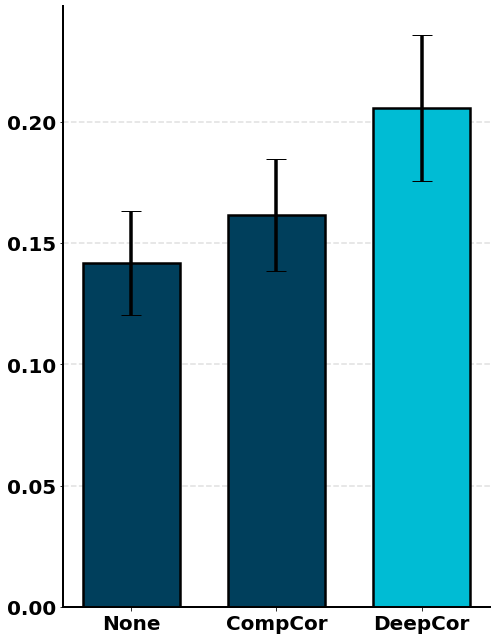

In [18]:
arrs = [vec_ffa,vec_compcor,vec_deepcor]

means = [arrs[0].mean(),arrs[1].mean(),arrs[2].mean()]
sems =[arrs[0].std(),arrs[1].std(),arrs[2].std()]
sems = np.array(sems) / np.sqrt(nsubs)

pretty_bar_plot(means,sems)

In [19]:
print(vec_ffa.mean())
print(vec_compcor.mean())
print(vec_deepcor.mean())

0.1417633337321652
0.16155510108410157
0.2056782143766414


In [20]:
pretty_t_test(vec_compcor,vec_ffa,'CompCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_ffa,'DeepCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_compcor,'DeepCor > CompCor: ')

CompCor > NoDenoise:  ΔM=0.020, t(9) = 3.82, p = 0.004
DeepCor > NoDenoise:  ΔM=0.064, t(9) = 3.91, p = 0.004
DeepCor > CompCor:  ΔM=0.044, t(9) = 2.47, p = 0.035


In [21]:
d1=vec_compcor.mean()-vec_ffa.mean()
d2=vec_deepcor.mean()-vec_compcor.mean()
print(d1)
print(d2)
print(f'Correlation improvement: {d2/d1:.2f}x')
print(f'Correlation improvement: {d2/d1*100:.0f}%')

0.019791767351936357
0.044123113292539845
Correlation improvement: 2.23x
Correlation improvement: 223%


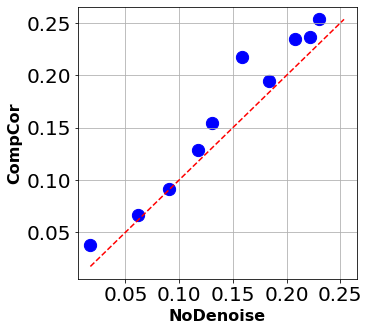

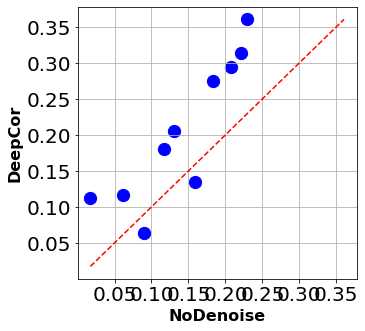

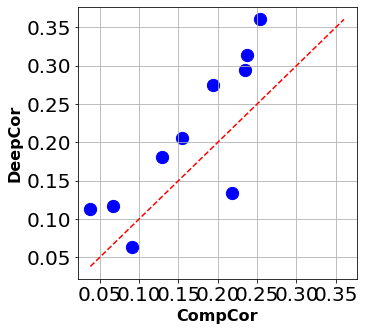

In [22]:
#idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

plt.figure(figsize=(5,5))
#plt.subplot(1,3,1);
plot_scatter(vec_ffa,vec_compcor,xlabel='NoDenoise',ylabel='CompCor',title='')
#plt.subplot(1,3,2);
plt.figure(figsize=(5,5))
plot_scatter(vec_ffa,vec_deepcor,xlabel='NoDenoise',ylabel='DeepCor',title='')
#plt.subplot(1,3,3);
plt.figure(figsize=(5,5))
plot_scatter(vec_compcor,vec_deepcor,xlabel='CompCor',ylabel='DeepCor',title='')

In [14]:
np.argsort(vec_deepcor-vec_compcor)

array([13,  7,  4,  6,  9,  1,  2,  5,  3, 10, 11,  0, 12,  8])

In [15]:
# idx = [0,1,2,3,4,5,6,7,8,13]

# plt.figure(figsize=(5,5))
# #plt.subplot(1,3,1);
# plot_scatter(vec_ffa[idx],vec_compcor[idx],xlabel='NoDenoise',ylabel='CompCor',title='')
# #plt.subplot(1,3,2);
# plt.figure(figsize=(5,5))
# plot_scatter(vec_ffa[idx],vec_deepcor[idx],xlabel='NoDenoise',ylabel='DeepCor',title='')
# #plt.subplot(1,3,3);
# plt.figure(figsize=(5,5))
# plot_scatter(vec_compcor[idx],vec_deepcor[idx],xlabel='CompCor',ylabel='DeepCor',title='')